@author: N. Laanait  
@email: laanaitn@ornl.gov  
@date: 10/13/2018

## Multi-Slice Simulation of Si (111) with mixed CPU/GPU code

Notes:
1. Running the code interactively could generate cuda errors for large # of probes (> 512) --> Use a python script for large simulations.
2. Some of the plots could take time to display.

In [1]:
from namsa import SupercellBuilder, MSAHybrid
from namsa.utils import imageTile
import numpy as np
import matplotlib.pyplot as plt
from time import time

#### Build Si(111) supercell from cif

In [2]:
sp = SupercellBuilder('XYZ_files/Si.cif')
z_dir = np.array([1,1,1])
y_dir = np.array([1,0,0])
sp.transform_unit_cell()
sp.make_orthogonal_supercell(supercell_size=np.array([4*34.6,4*34.6,489.0]),
                             projec_1=y_dir, projec_2=z_dir)

#### Setup scattering 

In [3]:
en = 100 # keV
semi_angle= 4e-3 # radians
max_ang = 200e-3
msa = MSAHybrid(en, semi_angle, sp.supercell_sites, sampling=np.array([1024,1024]), 
          verbose=True, debug=False)

Simulation Parameters:
Supercell dimensions xyz:[138.45 137.96 486.45] (Å)
Real, Reciprocal space pixel sizes:[0.14 0.13] Å, [0.01 0.01] 1/Å
Max angle: 0.27 (rad)
Sampling in real and reciprocal space: [1024 1024] pixels,
Thermal Effects: True


#### Calculate Atomic potentials

In [4]:
msa.calc_atomic_potentials()

##### Plot

Text(0.5,1,'Atom Potential for Z=14')

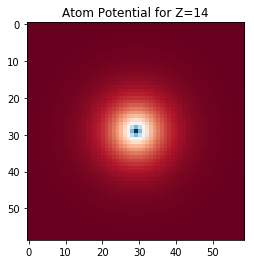

In [5]:
# Plot
itm = list(msa.cached_pots.keys())[0]
atom_pot = msa.cached_pots[itm]
fig, ax = plt.subplots()
ax.imshow(atom_pot**0.5, cmap='RdBu')
ax.set_title('Atom Potential for Z=%s'% itm)

#### Build Potential Slices

In [6]:
slice_thickness = 3.15 # Å
msa.build_potential_slices(slice_thickness)

Built 154 potential slices with shape:(1024, 1024) pixels


##### Plot

Text(0.5,1,'Projected Potential')

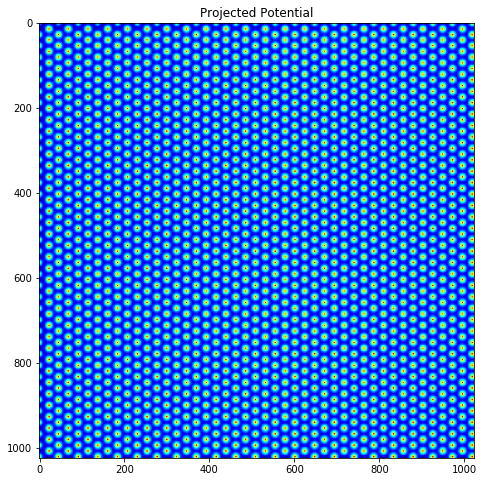

In [7]:
# Plot projected potential
projected_potential = msa.potential_slices.sum(0)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(projected_potential**0.25, cmap='jet')
ax.set_title('Projected Potential')

#### Build Electron Probe Wavefunction

In [15]:
aberration_params = {'C1':0., 'C3': 3.3e7, 'C5':0.0}
probe_params = {'smooth_apert': True, 'scherzer': False, 'apert_smooth': 60, 
                'aberration_dict':aberration_params, 'spherical_phase': True}
psi_x, psi_k, aperture = msa.build_probe(probe_position=[0,0], probe_dict=probe_params)

##### Plot

Text(0.5,1,'Phase-$\\Psi(k_x, k_y)$')

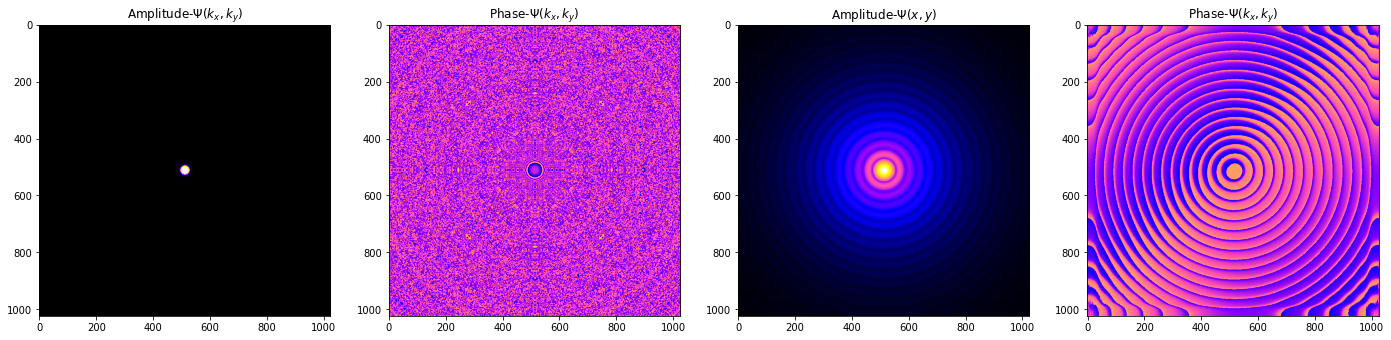

In [16]:
fig,axes = plt.subplots(1,4,figsize=(24,12))
axes[0].imshow(np.abs(psi_k)**0.5,cmap='gnuplot2')
axes[0].set_title('Amplitude-$\Psi(k_x, k_y)$')
axes[1].imshow(np.angle(psi_k), cmap='gnuplot2', interpolation='bilinear')
axes[1].set_title('Phase-$\Psi(k_x, k_y)$')
axes[2].imshow(np.abs(psi_x)**0.25, cmap='gnuplot2')
axes[2].set_title('Amplitude-$\Psi(x, y)$')
axes[3].imshow(np.angle(psi_x), cmap='gnuplot2', interpolation='bilinear')
axes[3].set_title('Phase-$\Psi(k_x, k_y)$')

#### Generate probe positions

In [17]:
msa.generate_probe_positions(probe_step=np.array([10.,10.]), 
                             probe_range=np.array([[0.25,0.75],[0.25,0.75]]))

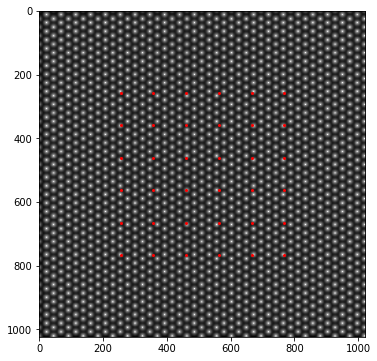

In [18]:
imp = msa.potential_slices.sum(0)
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(imp**0.25,cmap='gray')
for pos in msa.probe_positions:
    img_coords = np.array(imp.shape)//2-pos*msa.sampling/msa.dims[:2]
    ax.plot(img_coords[1], img_coords[0],marker='o',markersize=2,color='r')

#### Setup Simulation

In [19]:
msa.setup_device()
msa.plan_simulation(num_probes=msa.probe_positions.shape[0])

mem_alloc: 0.9256960000000001
free_mem: 15.2112
Simulation will propagate 36 probes simultaneously


#### Propagate Probe Positions

In [20]:
probes_arr = msa.multislice(save_probes=False)

Spent 18.7303 s building 36 probes on cpu
Propagated 36 probes in 1.9894 s


##### Plot

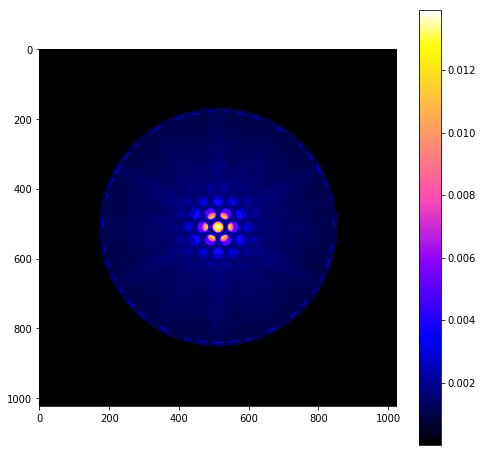

In [21]:
cbed = np.sum(np.abs(probes_arr)**2, axis=0)
fig,ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(cbed**0.25,cmap='gnuplot2')
plt.colorbar(cax)

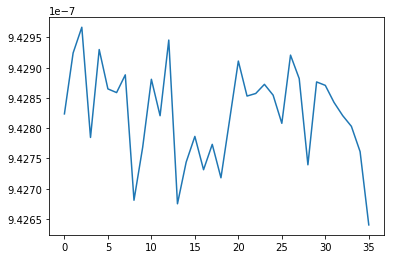

In [28]:
maxes=np.max(np.abs(probes_arr)**2,axis=(-1,1))
mines=np.min(np.abs(probes_arr)**2,axis=(-1,1))
meanes=np.sum(np.abs(probes_arr)**2,axis=(-1,1))
plt.figure()
# plt.plot(mines)
# plt.plot(mines)
plt.plot(meanes)

##### Plot individual CBED

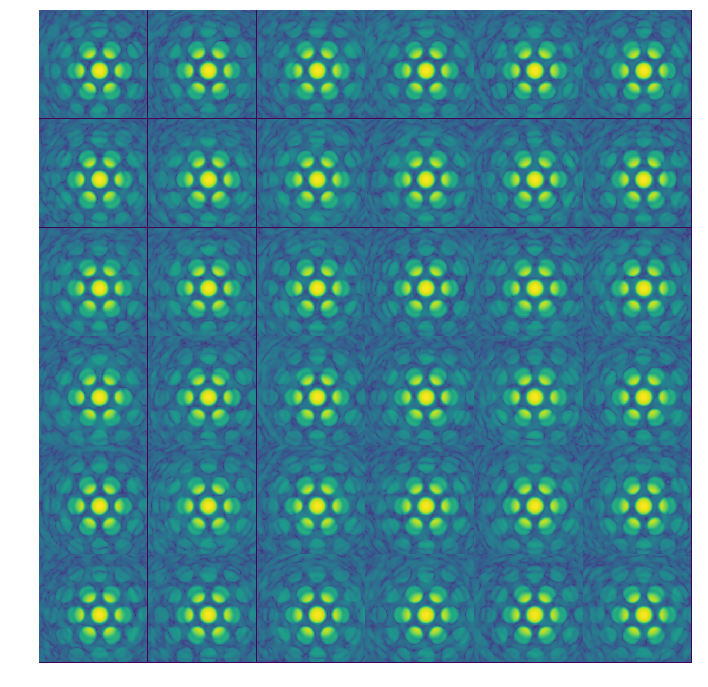

In [18]:
imageTile(np.abs(probes_arr[:, 400:600, 400:600])**0.25)